## Presentation

Please execute the cell below to view the slide presentation that the instructor will present at this time.

In [1]:
%%html
<iframe src="https://view.officeapps.live.com/op/embed.aspx?src=https://developer.download.nvidia.com:443/training/courses/C-MG-01-V3/task1/2-v2.pptx" width="610px" height="367px" frameborder="0"></iframe>

# A more realistic model

So far you've learned about the difference between gradient descent (i.e. a batch size equal to the full dataset) and mini-batch stochastic gradient descent (the batch size is smaller than the full dataset, usually much smaller). You've seen that smaller batch sizes add noise to the optimization process, which can help with avoiding getting trapped in local minima or slowed down at a saddle point. A smaller batch size will also mean running back-propagation and updating the gradients more times per epoch (taking more steps).

In this lab you'll be experimenting with batch size on a more complex dataset and model. You will see the effect of batch size on GPU performance, as well as on the accuracy of training.

## The Fashion-MNIST Dataset

The [Fashion-MNIST dataset](https://github.com/zalandoresearch/fashion-mnist) is a response to the traditional MNIST dataset, which is often referred to as the "hello world" of machine learning. The original MNIST dataset consists of 60,000 pictures of handwritten digits, 0-9. One of the downsides of this dataset is its simplicity. Good performance of a model on the dataset does not indicate that the model will perform well on a more complicated set of images.

The Fashion-MNIST dataset was created to be a moderately more complex image classification challenge. It follows the same format as the original MNIST set, with 10 categories and 60,000 images, each 28x28 pixels (plus 10,000 testing images). We'll be training on this dataset for this exercise, as well as for the next labs where we'll introduce training with multiple GPUs. 

<img src="./images/Fashion MNIST.png"> 

## The Wide ResNet Model

We'll be using a Wide Residual Network to train on this dataset, which is a convolutional neural network proven to perform very well in image classification challenges. Feel free to take some time to learn more about [wide residual networks](https://arxiv.org/abs/1605.07146), the original [residual networks](https://arxiv.org/abs/1512.03385) they are based on, or about [convolutional neural networks](https://developer.nvidia.com/discover/convolutional-neural-network) in general.

![wideresnet](./images/wideresnet.png)

In the early days of CNNs, the community drove towards very deep models (many tens or hundreds of layers), but as computing power advanced and algorithms improved, in particular after the idea of the residual block was demonstrated, it became more desirable to swing back towards shallower networks with wider layers, which was the primary innovation of the WideResNet family of models. The WideResNet-16-10 we will use below can achieve with O(10 million) parameters accuracy that is competitive with much deeper networks with more parameters.

## Training our Model

We'll start by running training on the existing dataset with default hyperparameters. Please take a few minutes to look through `fashion_mnist.py`, and get familiar with the training. We're using PyTorch for this training, but the takeaways of these exercises should translate to other frameworks.

Notice that we're only training on 1/6 of the dataset (10,000 images) for this exercise. We're doing this to keep epoch times short so that we can run quick experiments and see the effects of batch size. When we start introducing multiple GPUs to speed up the training, we'll use the entire dataset.

Once you have a good sense of the code, execute the cell below to run a few epochs. Pay attention to the validation accuracy, validation loss, and epoch time.

In [2]:
!python fashion_mnist.py --epochs 5

100%|█████████████████████████| 26421880/26421880 [00:02<00:00, 13202961.82it/s]
Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw

100%|█████████████████████████████████| 29515/29515 [00:00<00:00, 326456.41it/s]
Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw

100%|████████████████████████████| 4422102/4422102 [00:00<00:00, 6006062.56it/s]
Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw

100%|█████████████████████████████████| 5148/5148 [00:00<00:00, 50567393.42it/s]
Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw

Epoch =  1: Epoch Time = 18.149, Validation Loss = 0.507, Validation Accuracy = 0.809
Epoch =  2: Epoch Time = 17.441, Validation Loss = 0.432, Validation Accuracy = 0.844
Epoch =  3: Epoch Time = 17.527, Validation Loss = 0.401, Validation Accuracy = 0.857
Epoch =  4: Epoch Time = 17.549, Validation Loss = 0.365, Va

We are about to make some edits to this file, so let's make a copy of this file that you can refer to or back up to if you make any mistakes.

In [3]:
!cp fashion_mnist.py fashion_mnist_original.py

## Training Performance - Images/Second

One way of measuring the performance of our training is how much data is being processed for a given unit of time. GPUs are highly optimized for parallel processing, and many aspects of the training process utilize this parallelism. Take a moment to think about why batch size might have an effect on the GPUs ability to parallelize, and what might happen to the performance. 

In this exercise, you'll implement the feature to report how many images are processed each second as the neural network trains. You'll then adjust the batch size to see empirically how performance (or throughput) is affected.

### Computing Image Throughput

PyTorch gives us complete control over the training loop. We'll be making use of this flexibility to compute and report images/second throughput for each epoch. Take a moment to look at `TODO Step 1` locations in `fashion_mnist.py` and implement the image throughput calculation.

Once you've completed the implementation, execute the training again and pay attention to the image throughput.

If you get stuck, feel free to reference [solutions/fashion_mnist_after_step_01.py](solutions/fashion_mnist_after_step_01.py).

In [31]:
!python fashion_mnist.py --epochs 3

Epoch =  1: Epoch Time = 18.417, Validation Loss = 0.532, Validation Accuracy = 0.799 Image per Second = 542.122
Epoch =  2: Epoch Time = 17.564, Validation Loss = 0.427, Validation Accuracy = 0.847 Image per Second = 568.431
Epoch =  3: Epoch Time = 17.568, Validation Loss = 0.404, Validation Accuracy = 0.858 Image per Second = 568.301


You'll notice that the throughput increases after the first epoch. This can be attributed to one time costs such as data loading and memory allocation. For the next exercise, just focus on the throughput in the second epoch and beyond.

### Comparing Throughput by Batch Size

In this exercise you'll be calculating training throughput as a function of batch size. Execute the next cell several times as you adjust the batch size. Enter the data in the cell below (replace each "FIXME" with the images/sec throughput for the corresponding batch size), and execute it to see a plot of the data.

In [39]:
!python fashion_mnist.py --epochs 5 --batch-size 8

Epoch =  1: Epoch Time = 32.124, Validation Loss = 0.610, Validation Accuracy = 0.759 Image per Second = 311.294
Epoch =  2: Epoch Time = 31.342, Validation Loss = 0.499, Validation Accuracy = 0.815 Image per Second = 319.059
Epoch =  3: Epoch Time = 31.368, Validation Loss = 0.413, Validation Accuracy = 0.854 Image per Second = 318.798
^C
Traceback (most recent call last):
  File "fashion_mnist.py", line 189, in <module>
    train(model, optimizer, train_loader, loss_fn, device)
  File "fashion_mnist.py", line 108, in train
    labels = labels.to(device)
KeyboardInterrupt


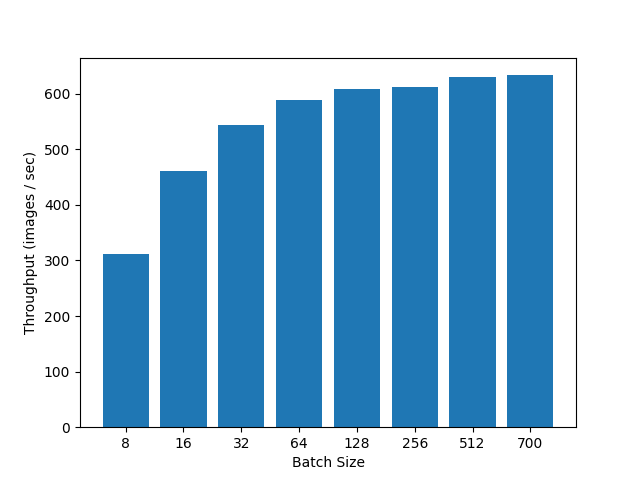

In [40]:
%matplotlib widget
import matplotlib.pyplot as plt

data = [('8', 311.294),
        ('16', 461.306),
        ('32', 543.788),
        ('64', 588.535),
        ('128', 608.817),
        ('256', 611.833),
        ('512', 630.021),
        ('700', 633.187)]

x,y = zip(*data)
plt.bar(x,y)
plt.ylabel("Throughput (images / sec)")
plt.xlabel("Batch Size")
plt.show()

If you don't want to manually find each datapoint, you can reveal the code block below and copy over the provided data. These values may vary slightly from what you may have produced with your own code, but were generated on the same compute environment as you are currently using.

```python
data = [('8', 322),
        ('16', 485),
        ('32', 575),
        ('64', 628),
        ('128', 652),
        ('256', 657),
        ('512', 680),
        ('700', 683)]
```

Take some time to look at the data and think about what might be going on. Once you have some hypotheses, reveal the block below.

It's clear that throughput is increasing with batch size. This makes sense due to the parallel processing nature of the GPU. A larger batch size means more images can be run through the model in parallel to calculate the loss before back-propagation. This takes advantage of the thousands of cores that are in the GPU. 

However, throughput does not increase linearly with batch size, and there are diminishing returns as the batch size increases. Eventually, you will have saturated the compute capacity of the GPU. GPUs work effectively when they can spawn tens or hundreds of thousands of threads at once, and for small batch sizes there's not enough to work use all the threads the GPU can execute. Since GPU processing performance depends on hiding latency by having lots of work to do, performance for small batches will be relatively poor, and performance for large enough batches will eventually use all the GPU cores effectively, and the throughput (number of images processed per second) will approach a ceiling.

## Training Performance: Time to Accuracy

At this point you might want to pick the highest possible batch size for training to achieve the highest throughput. However, while throughput is an important measurement of the training process, it doesn't indicate how well the model is being trained with respect to its purpose: inference. 

In our case, the model is only as good as its ability to correctly identify the class of clothing in a given image. Our measurement of this is reported in the validation accuracy, which reflects how effectively the model makes predictions on a separate dataset that we did not train on.

Think about how batch size might affect the model's ability to be accurate. Remember that noise introduced with smaller batch sizes is a helpful tool in the training process.

In this next exercise, you'll once again adjust batch size, comparing the total training time before a given accuracy is reached.

### Early Stopping

To implement early stopping, we have to specify a target accuracy as well as a patience value. The patience determines how many epochs should surpass a target accuracy before the training should stop. Sometimes validation accuracy can unexpectedly spike before the network is effectively trained. Maintaining a high accuracy over more than one epoch gives us a better confidence that the network is well-trained, and can generalize effectively.

Implement the early stopping feature in `fashion_mnist.py`. Look for `TODO Step 2`. Finally, run the training below with the given target accuracy and patience value. If you get stuck, you can check out `solutions/fashion_mnist_after_step_02.py`.

In [47]:
!python fashion_mnist.py --target-accuracy .82 --patience 2

Epoch =  1: Epoch Time = 18.218, Validation Loss = 0.535, Validation Accuracy = 0.801 Image per Second = 548.032, Cumulative Time of Training = 18.218
Epoch =  2: Epoch Time = 17.482, Validation Loss = 0.441, Validation Accuracy = 0.838 Image per Second = 571.109, Cumulative Time of Training = 35.700
Epoch =  3: Epoch Time = 17.545, Validation Loss = 0.390, Validation Accuracy = 0.859 Image per Second = 569.049, Cumulative Time of Training = 53.245
Early stopping after epoch 3


### Report Total Training Time

Now that you've got the training to stop after it reaches a certain accuracy, the next step is to report the total training time so that you can compare runs against each other. Look for `TODO Step 3` in `fashion_mnist.py`. If you get stuck, you can check out `solutions/fashion_mnist_after_step_03.py`.

Once you're done, run the file again to test out the functionality. For this exercise it's OK to use a lower target accuracy or to use a lower patience threshold, since we're just making sure we got the code right.

In [48]:
!python fashion_mnist.py --target-accuracy .7 --patience 2

Epoch =  1: Epoch Time = 18.445, Validation Loss = 0.521, Validation Accuracy = 0.797 Image per Second = 541.274, Cumulative Time of Training = 18.445
Epoch =  2: Epoch Time = 17.566, Validation Loss = 0.428, Validation Accuracy = 0.842 Image per Second = 568.380, Cumulative Time of Training = 36.011
Early stopping after epoch 2


### Comparing Accuracy with Batch Size

You now have a system to compare the effectiveness of batch size in terms of time to a certain accuracy (we suggest between .82 and .85). Try out several batch sizes to see the effects on the validation accuracy.  Notice what happens when your batch size is especially low or high. Consider repeating training with the same batch size one or multiple times to evaluate the consistency of the results. 

In [49]:
!python fashion_mnist.py --batch-size 32 --target-accuracy .85 --patience 2

Epoch =  1: Epoch Time = 18.478, Validation Loss = 0.521, Validation Accuracy = 0.803 Image per Second = 540.315, Cumulative Time of Training = 18.478
Epoch =  2: Epoch Time = 17.575, Validation Loss = 0.456, Validation Accuracy = 0.832 Image per Second = 568.067, Cumulative Time of Training = 36.054
Epoch =  3: Epoch Time = 17.594, Validation Loss = 0.393, Validation Accuracy = 0.857 Image per Second = 567.460, Cumulative Time of Training = 53.648
Epoch =  4: Epoch Time = 17.603, Validation Loss = 0.355, Validation Accuracy = 0.872 Image per Second = 567.163, Cumulative Time of Training = 71.251
Early stopping after epoch 4


Record and consider your results before revealing the next section.

The results you obtained probably pointed you in a couple of general directions. In particular, very small or large batch sizes may not be optimal for convergence (very small batches tend to be far too noisy to converge adequately to the minimum of the loss function, while very large batches tend to diverge in the early part of the training). However, you also probably saw that there's a lot of randomness in the results, and it is hard to generalize very well. That's OK, and it's actually a good thing, because not everything you learn today will apply the same way to every model and dataset. The goal of this course is to build intuition about how to think about the process of neural network optimization, not to learn a set of rules to apply blindly in production.

## Conclusion

In this part of the class we have learned:

- How to train a more sophisticated and realistic neural network model than the one we used before
- How to implement several custom features in PyTorch and measure training performance in terms of both accuracy and throughput
- How batch size affects training accuracy for a more realistic model

This concludes Lab 1. In Lab 2, we will learn how to extend this training process to multiple GPUs.

### Presentation

Before concluding this section please execute the cell below to view the slide presentation that the instructor present at this time.

In [16]:
%%html
<iframe src="https://view.officeapps.live.com/op/embed.aspx?src=https://developer.download.nvidia.com:443/training/courses/C-MG-01-V3/task1/3-v2.pptx" width="610px" height="367px" frameborder="0"></iframe>

In [54]:
!tar -cvf lab_1.tar

tar: Cowardly refusing to create an empty archive
Try 'tar --help' or 'tar --usage' for more information.
